## 第8章: 機械学習
> 本章では，Bo Pang氏とLillian Lee氏が公開しているMovie Review Dataのsentence polarity dataset v1.0を用い，文を肯定的（ポジティブ）もしくは否定的（ネガティブ）に分類するタスク（極性分析）に取り組む．

In [1]:
import nltk
import numpy as np

### 70. データの入手・整形
> 文に関する極性分析の正解データを用い，以下の要領で正解データ（sentiment.txt）を作成せよ．
1. rt-polarity.posの各行の先頭に"+1 "という文字列を追加する（極性ラベル"+1"とスペースに続けて肯定的な文の内容が続く）
2. rt-polarity.negの各行の先頭に"-1 "という文字列を追加する（極性ラベル"-1"とスペースに続けて否定的な文の内容が続く）
3. 上述1と2の内容を結合（concatenate）し，行をランダムに並び替える

> sentiment.txtを作成したら，正例（肯定的な文）の数と負例（否定的な文）の数を確認せよ．



In [2]:
%%bash
cd data
sed -e "s/^/+1 /" rt-polarity.pos > tmp.txt
sed -e "s/^/-1 /" rt-polarity.neg >> tmp.txt
sort -R tmp.txt > sentiment.txt
head sentiment.txt

+1 the film's images give a backbone to the company and provide an emotional edge to its ultimate demise . 
-1 not even steven spielberg has dreamed up such blatant and sickening product placement in a movie . 
-1 if swimfan does catch on , it may be because teens are looking for something to make them laugh . 
+1 the kind of primal storytelling that george lucas can only dream of . 
+1 funny in a sick , twisted sort of way . 
-1 for all its violence , the movie is remarkably dull with only caine making much of an impression . 
-1 a wretched movie that reduces the second world war to one man's quest to find an old flame . 
+1 sharp edges and a deep vein of sadness run through its otherwise comic narrative . 
+1 chaiken ably balances real-time rhythms with propulsive incident . 
+1 writer-director burger imaginatively fans the embers of a dormant national grief and curiosity that has calcified into chronic cynicism and fear . 


In [3]:
%%bash
cd data
grep -c ^+1 sentiment.txt
grep -c ^-1 sentiment.txt

5331
5331


### 71. ストップワード
> 英語のストップワードのリスト（ストップリスト）を適当に作成せよ．さらに，引数に与えられた単語（文字列）がストップリストに含まれている場合は真，それ以外は偽を返す関数を実装せよ．さらに，その関数に対するテストを記述せよ．

In [4]:
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = stopwords.words('english')

def is_stopword(word):
    return word in stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matsumaru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
assert is_stopword('the') == True
assert is_stopword('phosphorescence') == False

### 72. 素性抽出
> 極性分析に有用そうな素性を各自で設計し，学習データから素性を抽出せよ．素性としては，レビューからストップワードを除去し，各単語をステミング処理したものが最低限のベースラインとなるであろう．

In [6]:
import chardet

In [7]:
with open('./data/sentiment.txt', 'rb') as f:
    print(chardet.detect(f.read()))

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


In [8]:
class Bag_of_Words(object):
    def __init__(self):
        self.word_to_ix = {}
        self.ix_to_word = {}
        self.word_count = 0

    def add_word(self, word):
        if word not in self.word_to_ix:
            self.word_to_ix[word] = self.word_count
            self.ix_to_word[self.word_count] = word
            self.word_count += 1

def feature_extract(sentence, bow):
    word_list = [word for word in sentence.split(' ') if not is_stopword(word)]
    vec = np.zeros(bow.word_count)
    for word in word_list:
        word = PS.stem(word)
        if word in bow.word_to_ix:
            vec[bow.word_to_ix[word]] += 1
    return vec

BoW = Bag_of_Words()
PS = nltk.stem.porter.PorterStemmer()
with open('./data/sentiment.txt', encoding='Windows-1252') as f:
    for line in f:
        sentence = line[3:]
        for word in sentence.split(' '):
            word = PS.stem(word)
            BoW.add_word(word)

example = 'one of those unassuming films that sneaks up on you and stays with you long after you have left the theatre . '
feature_extract(example, BoW)

array([0., 0., 0., ..., 0., 0., 0.])

In [9]:
sum(feature_extract(example, BoW))

10.0

In [10]:
X = []
Y = []

with open('./data/sentiment.txt', encoding='Windows-1252') as f:
    for line in f:
        y, x = line.split(' ', 1)
        X.append(feature_extract(x, BoW))
        Y.append(int(y))

### 73. 学習
> 72で抽出した素性を用いて，ロジスティック回帰モデルを学習せよ．

In [11]:
from sklearn.linear_model import LogisticRegression

Model = LogisticRegression()
Model.fit(X, Y)
Model.score(X, Y)

0.9529169011442506

### 74. 予測
> 73で学習したロジスティック回帰モデルを用い，与えられた文の極性ラベル（正例なら"+1"，負例なら"-1"）と，その予測確率を計算するプログラムを実装せよ．

In [19]:
sentences = ['alice was beginning to get very tired of sitting by her sister on the bank , and of having nothing to do .',
             'That is exactly the way I wanted it !']
test = [feature_extract(sentence, BoW) for sentence in sentences]
for label, proba in zip(Model.predict(test), Model.predict_proba(test)):
    if label == 1:
        print('label: +1, probability:', max(proba))
    else:
        print('label: -1, probability:', max(proba))

label: -1, probability: 0.808964699896107
label: +1, probability: 0.500671783927467


### 75. 素性の重み
> 73で学習したロジスティック回帰モデルの中で，重みの高い素性トップ10と，重みの低い素性トップ10を確認せよ．

In [13]:
weights = {BoW.ix_to_word[i]: x for i, x in enumerate(Model.coef_[0])}
weights = sorted(weights.items(), key=lambda x: x[1])
print('High 10: ', *reversed(weights[-10:]), sep='\n')
print('Low 10: ', *weights[:10], sep='\n')

High 10: 
('engross', 2.1193399499112995)
('refresh', 1.9430706022219832)
('unexpect', 1.855804521299073)
('smarter', 1.6964655892987774)
('remark', 1.6240876173915837)
('resist', 1.6016081414424213)
('beauti', 1.5498483994896806)
('lane', 1.5444484957917055)
('mesmer', 1.4900942395957422)
('examin', 1.4767152568582094)
Low 10: 
('bore', -2.1998082984779948)
('dull', -1.9619584911539347)
('neither', -1.8887373169756692)
('wast', -1.874116887319212)
('fail', -1.8547313576056472)
('mediocr', -1.8524631585549594)
('appar', -1.7733922941311118)
('worst', -1.7631905970782054)
('badli', -1.7427138241620073)
('routin', -1.7029632730630255)


### 76. ラベル付け
> 学習データに対してロジスティック回帰モデルを適用し，正解のラベル，予測されたラベル，予測確率をタブ区切り形式で出力せよ．

In [14]:
def output_predict(model, X, Y):
    for true, pred, proba in zip(Y, model.predict(X), model.predict_proba(X)):
        yield true, pred, max(proba)

for i, output in enumerate(output_predict(Model, X, Y)):
    if i == 10:
        break
    print(*output, sep='\t')

1	1	0.9744339798160324
-1	-1	0.7385499495384062
-1	-1	0.5726916847073221
1	1	0.6838301956607635
1	1	0.7143125526381386
-1	-1	0.8078692407639353
-1	1	0.5085058044308296
1	1	0.9721689730922698
1	1	0.9155870421938627
1	1	0.7123847357095636


### 77. 正解率の計測
> 76の出力を受け取り，予測の正解率，正例に関する適合率，再現率，F1スコアを求めるプログラムを作成せよ．

In [15]:
true_positive = 0
pred_positive = 0
both_positive = 0
correct = 0
for true, pred, _ in output_predict(Model, X, Y):
    if true == 1: 
        true_positive += 1
    if pred == 1: 
        pred_positive += 1
    if true == pred: 
        correct += 1
        if true == 1:
            both_positive += 1

accuracy = correct / len(Y)
print('accuracy:', accuracy)
precision = both_positive / pred_positive
print('precision:', precision)
recall = both_positive / true_positive
print('recall:', recall)
F_measure = 2 * precision * recall / (precision + recall)
print('F_measure:', F_measure)

accuracy: 0.9529169011442506
precision: 0.9556520098131723
recall: 0.9499155880697805
F_measure: 0.95277516462841


### 78. 5分割交差検定
> 76-77の実験では，学習に用いた事例を評価にも用いたため，正当な評価とは言えない．すなわち，分類器が訓練事例を丸暗記する際の性能を評価しており，モデルの汎化性能を測定していない．そこで，5分割交差検定により，極性分類の正解率，適合率，再現率，F1スコアを求めよ．

In [16]:
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 
           'precision',
           'recall',
           'f1']

scores = cross_validate(Model, X, Y, cv=5, scoring=scoring, return_train_score=False)

In [17]:
del scores['fit_time']
del scores['score_time']
scores

{'test_accuracy': array([0.76804124, 0.74859287, 0.74812383, 0.74718574, 0.77157598]),
 'test_precision': array([0.77134725, 0.75047259, 0.74023615, 0.74603175, 0.77081384]),
 'test_recall': array([0.76194939, 0.74484053, 0.76454034, 0.74953096, 0.77298311]),
 'test_f1': array([0.76661952, 0.74764595, 0.75219197, 0.74777726, 0.77189696])}

### 79. 適合率-再現率グラフの描画
> ロジスティック回帰モデルの分類の閾値を変化させることで，適合率-再現率グラフを描画せよ．

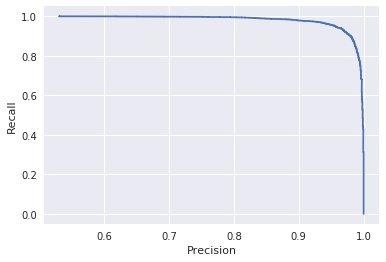

In [18]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

# acquire the precision and recall rate value at a certain threshold
precision, recall, threshold = precision_recall_curve(Y, Model.predict_proba(X)[:, 1])

plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')

plt.show()